# Congestion Management Using Q-learning (Reinforcement learning)

First, I increase the loadprofile to add some congestion to the grid.

In [1]:
import pandapower as pp
import pandapower.networks as pn

congestion_limit = 100.0

# Create system
def create_case():
    net = pn.case9()  # Load a pandapower case
    
    # Set line loading limits (assume 80% of max capacity as congestion threshold)
    for i in range(len(net.line)):
        net.line.loc[i, "max_loading_percent"] = congestion_limit
    
    # 1.3 scaling for line 1 and loadstep of 1.4
    for i in range(len(net.load)): # range(len(net.load))
        net.load.loc[i, "p_mw"] *= 1.3
        net.load.loc[i, "q_mvar"] *= 1.3
    
    return net

net = create_case()
pp.runpp(net)  # Run initial power flow
# print(net.load)
# print(net.gen)
# print(net.line)

# print(net.res_line.loading_percent)

#net.line.loc[3, "in_service"] = False
#net.load.loc[7, "p_mw"] *= 1.2 #[5, 7, 12]
pp.runpp(net)
#print(net.res_line.loading_percent)


In [2]:
import gym
import numpy as np
import torch
from gym import spaces

class PowerGridEnv(gym.Env):
    def __init__(self):
        super(PowerGridEnv, self).__init__()

        self.net = create_case()  # Load power system model

        # Observation space: includes line loading percentages and generator outputs
        num_lines = len(self.net.line)  # Number of transmission lines
        num_gens = len(self.net.gen)    # Number of generators
        num_loads = len(self.net.load)  # Number of loads
        num_buses = len(self.net.bus)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(num_lines + num_gens + num_loads,), dtype=np.float32 # line flows, gen setpoints and voltage angles
        ) # this is the observation space for continuous variables, all scaled between zero and one

        # Action space: Discrete set of actions for generator redispatch
        # Each generator has three actions: increase, maintain or decrease output
        self.action_space = spaces.Discrete(num_gens * 3)

        self.state = self.get_state()  # Initialize state
        self.prev_line_loadings = self.net.res_line.loading_percent.copy()  # Store initial line loading
        
        self.threshold = 0.1 # penalty threshold 

    def get_state(self):
        """Extracts the system state: Line loading percentages & generator outputs"""
        pp.runpp(self.net)  # Run a power flow simulation

        # Normalize line loadings (divide by 100%)
        line_loadings = self.net.res_line.loading_percent / 100.0

        # Normalize generator outputs (divide by max capacity)
        gen_p = self.net.res_gen.p_mw / self.net.gen.max_p_mw
        
        # Normalize generator outputs (divide by max capacity)
        load_p = self.net.res_load.p_mw / self.net.load.p_mw
        
        # Normalize generator outputs (divide by max capacity)
        bus_vm = (self.net.res_bus.vm_pu - self.net.bus.min_vm_pu) / (self.net.bus.max_vm_pu - self.net.bus.min_vm_pu) # min max scaling of voltage magnitude so [0, 1]

        # Normalize generator outputs (divide by max capacity)
        bus_va = (self.net.res_bus.va_degree * (np.pi / 180) - ( - np.pi/2)) / (2*np.pi) # min max scaling of angle to be within [-pi, pi] so angles are between [0, 1]

        # Return the combined state vector
        return np.concatenate((line_loadings, gen_p, load_p)) # np.concatenate((line_loadings, gen_p, load_p, bus_vm, bus_va))


    def apply_action(self, action):
        gen_idx = action // 3  # Determine generator
        action_type = action % 3  # 0: increase, 1: decrease, 2: no change

        change = 1 if action_type == 0 else -1 if action_type == 1 else 0  # Define change direction

        # Apply generator redispatch while keeping within limits
        new_dispatch = np.clip(
            self.net.gen.loc[gen_idx, "p_mw"] + change * 1,  
            self.net.gen.loc[gen_idx, "min_p_mw"],  
            self.net.gen.loc[gen_idx, "max_p_mw"]
        )

        # print(f"Action {action}: Adjusting generator {gen_idx} to {new_dispatch:.2f} MW")  # Debugging

        self.net.gen.loc[gen_idx, "p_mw"] = new_dispatch

    def step(self, action):
        """Takes an action (redispatches a generator) and updates the system"""
        # Apply the action to the generator dispatch
        self.apply_action(action)

        # Run power flow after applying the action
        pp.runpp(self.net)

        next_state = self.get_state()  # Compute new state
        
        # Calculate the penalty based on line loading exceeding the congestion limit
        line_loading_penalty = 0.0
        for index, loading in enumerate(self.net.res_line.loading_percent):
                if loading > congestion_limit:  # Exceeds limit
                    line_loading_penalty -= 1 #np.abs(loading-congestion_limit) #1.0  # Penalize excess loading
            

        # Penalty for violating voltage limits
        overvoltage_penalty = -np.sum(np.maximum(self.net.res_bus.vm_pu - self.net.bus.max_vm_pu, 0))  # Overvoltage penalty
        undervoltage_penalty = np.sum(np.minimum(self.net.res_bus.vm_pu - self.net.bus.min_vm_pu, 0))  # Overvoltage penalty

        # Reward for minimizing power imbalance
        power_imbalance = np.abs(self.net.res_gen.p_mw.sum() - self.net.res_load.p_mw.sum() + self.net.res_ext_grid.p_mw.sum())

        # Total reward
        reward = (line_loading_penalty)
        
        # Update the previous line loadings for the next step
        self.prev_line_loadings = self.net.res_line.loading_percent.copy()

        done = False  # The episode does not terminate early
        return next_state, reward, done, {}


    def reset(self):
        """Resets the environment by applying a random load change to simulate congestion"""
        self.net = create_case()  # Reload the system

        # Randomly choose whether to apply a load change or take a line out of service
        action_type = np.random.choice(['load', 'line'])  # Randomly choose between 'load' and 'line'
        action_type = 'load'
        
        
        if action_type == 'load':
            # Select a random load bus 
            random_load_idx = np.random.choice([2])  # Random load bus index
            variation = 1.4 #np.random.uniform(0.8, 1.4)  # Random factor between 80% and 120%. 1.4!
            self.net.load.loc[random_load_idx, "q_mvar"] *= variation  
            self.net.load.loc[random_load_idx, "p_mw"] *= variation  # Apply the load change
            
            print(f"Applied load change to load bus {random_load_idx}, variation: {variation:.2f}")
        
        elif action_type == 'line':
            # Select a random line and set it out of service
            random_line_idx = np.random.choice([3])  # Randomly select a line index
            self.net.line.loc[random_line_idx, "in_service"] = False  # Set the line out of service
            
            print(f"Set line {random_line_idx} out of service")

        return self.get_state()  # Return the new initial state, for the 9-bus system line 1,5 works


In [3]:
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque # double ended queue. It's an efficient data structure for adding/removing elements from both ends.

class DQN(nn.Module):
    """Defines a simple Deep Q-Network with two hidden layers"""
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 128)         # Second hidden layer
        self.fc3 = nn.Linear(128, output_dim) # Output layer

    def forward(self, x):
        """Forward pass through the neural network"""
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Output Q-values for all possible actions

# Initialize RL environment
env = PowerGridEnv()
input_dim = env.observation_space.shape[0]  # Number of state variables
output_dim = env.action_space.n  # Number of actions

# Create two networks: policy and target (for stability)
policy_net = DQN(input_dim, output_dim) # this is the actor, and decides which action to take based on the current state
target_net = DQN(input_dim, output_dim) # this is the value network (the critic), estimates future reward of a state, which helps guide the agent in training.
target_net.load_state_dict(policy_net.state_dict())  # Copy weights to target network

# initialize nn weights
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

policy_net.apply(init_weights)
target_net.apply(init_weights)

# Define optimizer and loss function
optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
loss_fn = nn.SmoothL1Loss() # nn.SmoothL1Loss()  Huber loss , nn.MSELoss()

# Replay memory buffer
memory = deque(maxlen=10000)  # when maxlen is reached, old experiences are removed to keep memory usage under control

# RL training parameters
gamma = 0.99        # Discount factor, 0.95
epsilon = 0.1       # Initial exploration rate (epsilon-greedy), 1.0 
epsilon_min = 0.01  # Minimum exploration rate, 0.01
epsilon_decay = 0.995  # Decay rate for exploration, 0.995
batch_size = 32     # Mini-batch size

def select_action(state, epsilon):
    """
    Select an action using epsilon-greedy strategy
    Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly.
    The probability of choosing a random action is epsilon, which decays over time.    
    """
    if np.random.rand() < epsilon:
        return np.random.randint(output_dim)  # Random action (exploration)
    with torch.no_grad():
        q_values = policy_net(torch.tensor(state, dtype=torch.float32))
        # print("Greedy action taken.")
    return torch.argmax(q_values).item()  # Greedy action (exploitation)

# Initialize lists to track rewards and losses
episode_rewards = []  # To store total reward per episode
episode_losses = []   # To store loss per episode

# Training loop
num_episodes = 10  # Number of training episodes/scenarios

for episode in range(num_episodes):
    state = env.reset()  # Reset environment
    # print(env.net.res_line.loading_percent)
    total_reward = 0  # Track total reward
    episode_loss = 0  # Track cumulative loss for this episode

    for t in range(1000):  # Max steps per episode
        action = select_action(state, epsilon)  # Choose action
        next_state, reward, done, _ = env.step(action)  # Take step in env
        
        if np.all(env.net.res_line.loading_percent < congestion_limit):  
            done = True  # End the episode if the condition is met
            reward = 0

        # Store experience in replay buffer
        memory.append((state, action, reward, next_state, done))
        state = next_state  # Update state
        total_reward += reward  # Accumulate reward

        # Train only if we have enough samples in memory
        if len(memory) > batch_size:
            # Sample a batch from memory
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert to tensors
            states = torch.tensor(states, dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)  # Ensure correct shape
            rewards = torch.tensor(rewards, dtype=torch.float32)
            next_states = torch.tensor(next_states, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)

            # Compute target Q-values
            next_q_values = target_net(next_states).max(1)[0].detach()  # Max Q-value from target net
            target_q_values = rewards + (gamma * next_q_values * (1 - dones))  # Bellman equation

            # Compute current Q-values from policy net
            q_values = policy_net(states).gather(1, actions).squeeze()  # Select Q-value for taken action

            # Compute loss (Mean Squared Error)
            loss = loss_fn(q_values, target_q_values)
            episode_loss += loss.item()  # Add to cumulative loss

            # Optimize policy network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            ##################### for debugging
            # Get line loading percentages
            # line_loadings = env.net.res_line.loading_percent

            # # Check for congestion
            # congested_lines = np.where(line_loadings > congestion_limit)[0]  # Indices of overloaded lines
            
            # # Print status
            # if len(congested_lines) > 0:
            #     print(f"Step {t+1}: 🚨 CONGESTION DETECTED on line(s) {list(congested_lines)}")
            #     for line in congested_lines:
            #         print(f"   🔴 Line {line}: {line_loadings[line]:.2f}% loaded (limit {congestion_limit}%)")
            # else:
            #     print(f"Step {t+1}: ✅ No congestion. Max line loading: {max(line_loadings):.2f}%")
            #######################
        
        if done:  # Exit the loop if episode is done early
            print(f"Stopping due to stable operation at iteration number {t}")
            break

    # Append reward and loss for the episode
    episode_rewards.append(total_reward)
    episode_losses.append(episode_loss)
    print(f"Episode loss: {episode_loss}")

    # Decay exploration rate
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    print(f"Episode {episode+1}: Total Reward = {total_reward}")

    # Update target network every 10 episodes
    if episode % 5 == 0:
        target_net.load_state_dict(policy_net.state_dict())


Applied load change to load bus 2, variation: 1.40


C:\Users\bagir\AppData\Local\Temp\ipykernel_23496\3405726718.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)


Stopping due to stable operation at iteration number 71
Episode loss: 16.09647834300995
Episode 1: Total Reward = -71.0
Applied load change to load bus 2, variation: 1.40
Stopping due to stable operation at iteration number 6
Episode loss: 2.34577539563179
Episode 2: Total Reward = -6.0
Applied load change to load bus 2, variation: 1.40
Stopping due to stable operation at iteration number 297
Episode loss: 19.22935693961699
Episode 3: Total Reward = -297.0
Applied load change to load bus 2, variation: 1.40
Stopping due to stable operation at iteration number 4
Episode loss: 0.014402674438315444
Episode 4: Total Reward = -4.0
Applied load change to load bus 2, variation: 1.40
Stopping due to stable operation at iteration number 6
Episode loss: 0.05665748327737674
Episode 5: Total Reward = -6.0
Applied load change to load bus 2, variation: 1.40
Stopping due to stable operation at iteration number 4
Episode loss: 0.02835125706042163
Episode 6: Total Reward = -4.0
Applied load change to lo

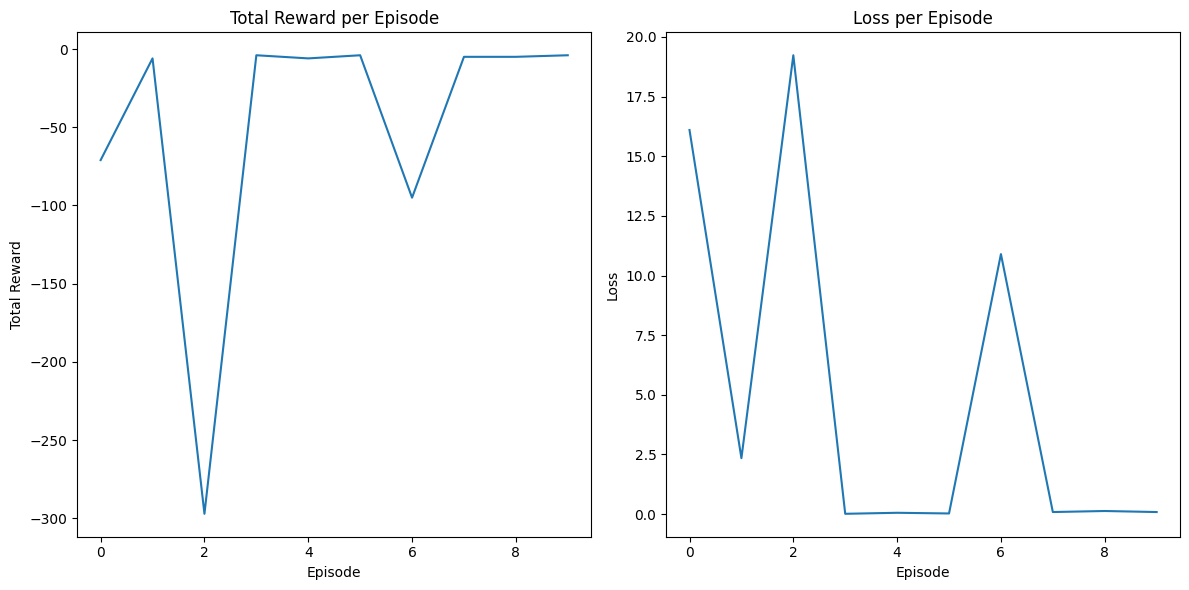

In [4]:
import matplotlib.pyplot as plt

# Plotting the total reward per episode
plt.figure(figsize=(12, 6))

# Plot Total Reward
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(episode_losses)
plt.title('Loss per Episode')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Show the plots
plt.tight_layout()
plt.show()


# Explaining the Policy Network

The policy network outputs q-values. Q-values represent the expected cumulative future rewards for taking a particular action in a given state. The output of your policy network will be a vector of Q-values, one for each possible action in the given state. So if you have multiple actions, the output for a given state will be the Q-value for each of those actions.

In [5]:
import shap
import torch
import numpy as np
import pandas as pd
import pandapower as pp

# Step 1: Extract input features from the environment
def get_features(env):
    """Extracts relevant features from the power network"""
    return np.hstack([
        env.net.res_line.loading_percent.values,  # Line loading levels
        env.net.gen.p_mw.values,        # Active power of generators
        env.net.load.p_mw.values,       # Active power of loads
        #env.net.res_bus.vm_pu.values,        # Active power of generators
        #env.net.res_bus.va_degree.values,  # Line loading levels
        
    ])

# Step 2: Define a SHAP explainer wrapper for the RL model
class RLModelWrapper:
    """Wrapper to apply SHAP analysis to a PyTorch RL agent"""
    def __init__(self, model):
        self.model = model
    
    def predict(self, X):
        """Predict actions using the RL model given feature matrix X"""
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            return self.model(X_tensor).numpy()  # Model output (e.g., redispatch decision)

# Step 3: Initialize SHAP Explainer
def run_shap_analysis(model, env, num_samples=100):
    """
    Runs SHAP analysis on the trained RL model for congestion management.
    """
    explainer_env_states = []
    congested_states = []
    
    # Collect states by running the environment
    state = env.reset()
    for t in range(num_samples):
        action = select_action(state, epsilon=0.0)  # Fully greedy policy for SHAP
        # print("this is the action: ", action)
        # print("this is action type: ", action % 3)
        # print(f"Before step: {get_features(env)}")
        next_state, _, _, _ = env.step(action)
        #print(f"After step: {get_features(env)}")
        pp.runpp(env.net)  # Simulate power flow
        explainer_env_states.append(get_features(env))  # Store input features
        state = next_state
        
        # Get line loading percentages
        line_loadings = env.net.res_line.loading_percent

        # Check for congestion
        congested_lines = np.where(line_loadings > congestion_limit)[0]  # Indices of overloaded lines

        # Print status
        if len(congested_lines) > 0:
            print(f"Step {t+1}: 🚨 CONGESTION DETECTED on line(s) {list(congested_lines)}")
            congested_states.append(t)
            for line in congested_lines:
                print(f"   🔴 Line {line}: {line_loadings[line]:.2f}% loaded (limit {congestion_limit}%)")
        else:
            print(f"Step {t+1}: ✅ No congestion. Max line loading: {max(line_loadings):.2f}%")
    
    # Convert to NumPy array
    X = np.array(explainer_env_states)
    
    # Initialize SHAP explainer
    wrapped_model = RLModelWrapper(model)
    explainer = shap.Explainer(wrapped_model.predict, X)
    
    expected_value = np.mean(wrapped_model.predict(X), axis = 0)
    
    # Compute SHAP values
    shap_explainer = explainer(X)
    
    # Step 4: Plot SHAP Summary
    feature_names = [f"Line Loading {i+1}" for i in range(len(env.net.res_line))] + \
                    [f"Gen Setpoint {i+1}" for i in range(len(env.net.gen))] + \
                    [f"Demand {i+1}" for i in range(len(env.net.load))] 
                    
                    
                    # [f"Va {i+1}" for i in range(len(env.net.bus))] + \
                    #[f"Vm {i+1}" for i in range(len(env.net.bus))] + \

    print(f"SHAP values shape: {shap_explainer.shape}")
    print(f"Feature matrix shape: {X.shape}")
    print(f"number of congested states: {len(congested_states)}")
    
    return shap_explainer, X, feature_names, congested_states, expected_value

# Run SHAP Analysis on the policy network (which decides redispatch)
shap_explainer, X, feature_names, congested_states, expected_value = run_shap_analysis(policy_net, env)

# print the JS visualization code to the notebook
shap.initjs()


c:\Users\bagir\AppData\Local\anaconda3\envs\shap\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Applied load change to load bus 2, variation: 1.40
Step 1: 🚨 CONGESTION DETECTED on line(s) [0]
   🔴 Line 0: 101.48% loaded (limit 100.0%)
Step 2: 🚨 CONGESTION DETECTED on line(s) [0]
   🔴 Line 0: 101.09% loaded (limit 100.0%)
Step 3: 🚨 CONGESTION DETECTED on line(s) [0]
   🔴 Line 0: 100.69% loaded (limit 100.0%)
Step 4: 🚨 CONGESTION DETECTED on line(s) [0]
   🔴 Line 0: 100.30% loaded (limit 100.0%)
Step 5: ✅ No congestion. Max line loading: 99.91%
Step 6: ✅ No congestion. Max line loading: 99.51%
Step 7: ✅ No congestion. Max line loading: 99.12%
Step 8: ✅ No congestion. Max line loading: 98.73%
Step 9: ✅ No congestion. Max line loading: 98.34%
Step 10: ✅ No congestion. Max line loading: 97.95%
Step 11: ✅ No congestion. Max line loading: 97.57%
Step 12: ✅ No congestion. Max line loading: 97.18%
Step 13: ✅ No congestion. Max line loading: 96.79%
Step 14: ✅ No congestion. Max line loading: 96.41%
Step 15: ✅ No congestion. Max line loading: 96.02%
Step 16: ✅ No congestion. Max line loadin

PermutationExplainer explainer: 101it [00:15,  2.94it/s]                         

SHAP values shape: (100, 14, 6)
Feature matrix shape: (100, 14)
number of congested states: 28


## Why Does the Policy Agent Make Decisions?

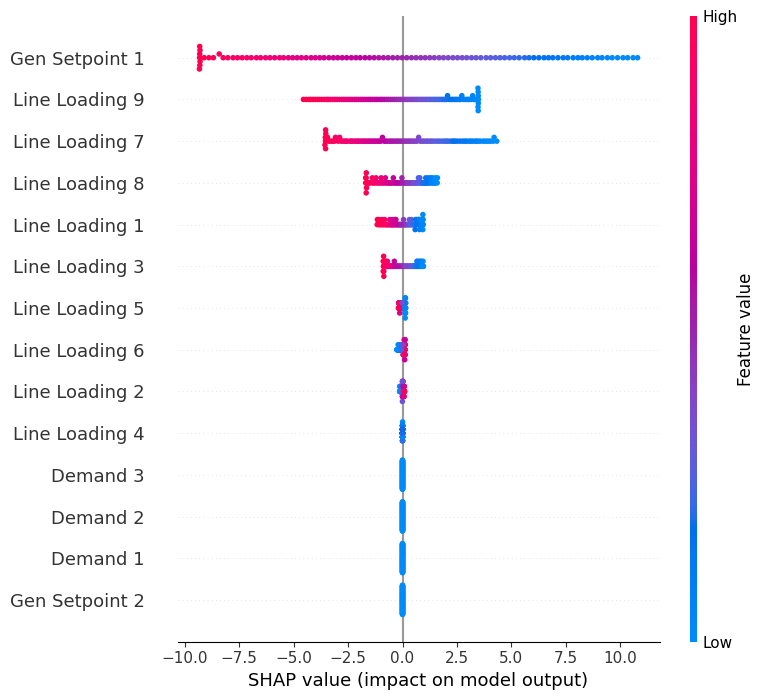

In [20]:
# 0: increase, 1: decrease, 2: no change
fig=plt.gcf()
shap.summary_plot(shap_explainer.values[:,:,5], X, feature_names=feature_names)
fig.savefig('figures/regression/beeswarm_global_nothing2.png', bbox_inches='tight')

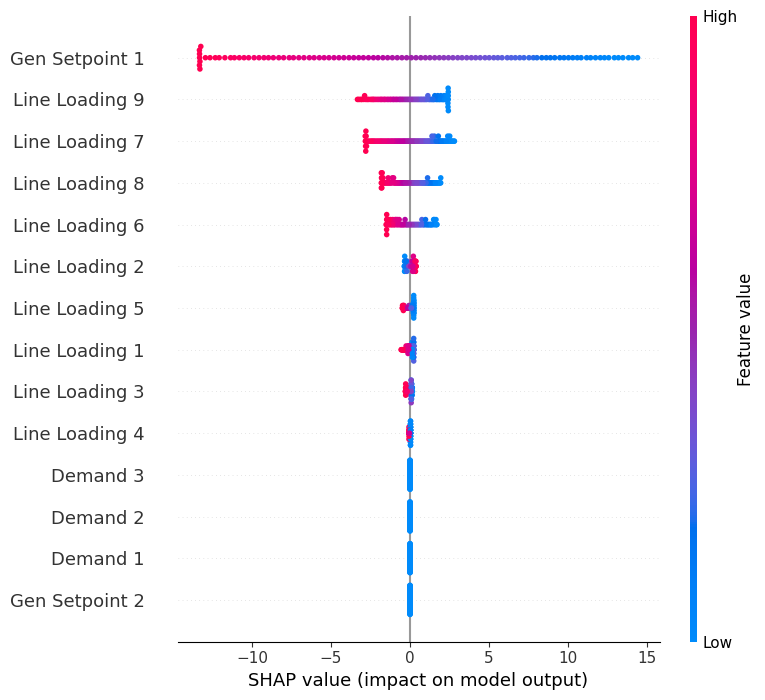

In [21]:
# 0: increase, 1: decrease, 2: no change
fig=plt.gcf()
shap.summary_plot(shap_explainer.values[:,:,3], X, feature_names=feature_names)
fig.savefig('figures/regression/beeswarm_global_increase2.png', bbox_inches='tight')

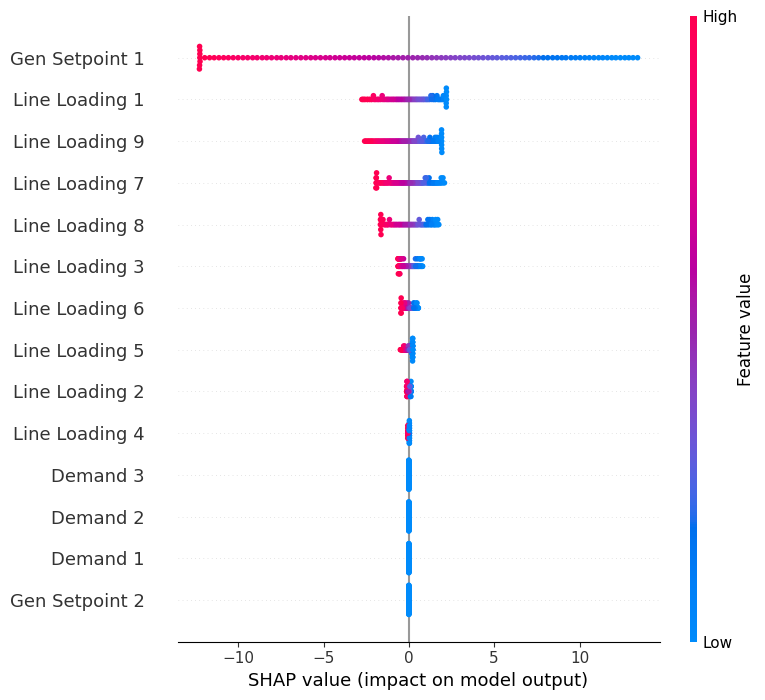

In [22]:
# 0: increase, 1: decrease, 2: no change
fig=plt.gcf()
shap.summary_plot(shap_explainer.values[:,:,4], X, feature_names=feature_names)
fig.savefig('figures/regression/beeswarm_global_decrease2.png', bbox_inches='tight')

In [9]:
# 0 is increase
force_plot = shap.force_plot(expected_value[0], shap_explainer.values[congested_states[0],:,0], feature_names)

# Save as an HTML file
shap.save_html('figures/regression/force_increase_local.html', force_plot)

In [10]:
# 1 is decrease
force_plot = shap.force_plot(expected_value[0], shap_explainer.values[congested_states[0],:,1], feature_names)

# Save as an HTML file
shap.save_html('figures/regression/force_decrease_local.html', force_plot)

In [11]:
# 2 is no change
force_plot = shap.force_plot(expected_value[0], shap_explainer.values[congested_states[0],:,2], feature_names)

# Save as an HTML file
shap.save_html('figures/regression/force_nothing_local.html', force_plot)

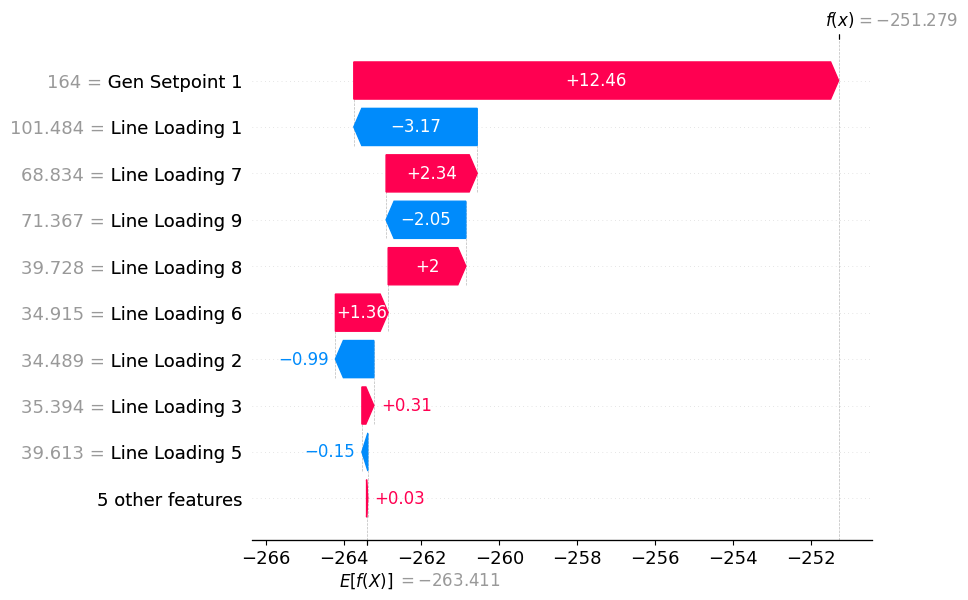

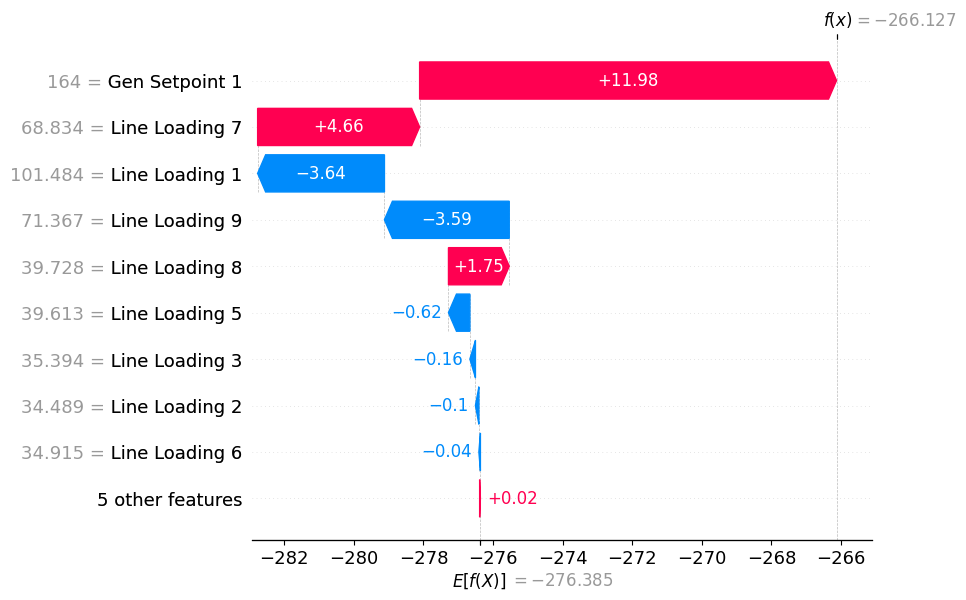

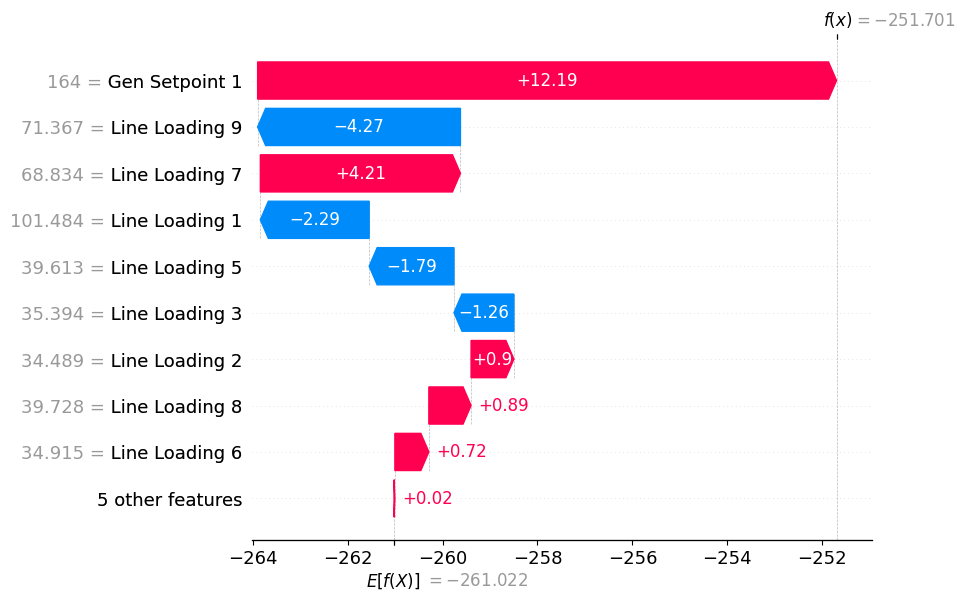

In [12]:
# explain the first congested state
shap_explainer.feature_names = feature_names # add feature names manually
shap.plots.waterfall(shap_explainer[congested_states[0],:,0], max_display = 10) # increase
shap.plots.waterfall(shap_explainer[congested_states[0],:,1], max_display = 10) # decrease
shap.plots.waterfall(shap_explainer[congested_states[0],:,2], max_display = 10) # no change